In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp 
import json
from tqdm import tqdm
import random

%cd ..  
from datasets.bases import read_image
from utils.metrics import *
from analyse import *
import umap
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap


/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID


In [2]:
# Load stuff

qf_noadapt = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/noadapt/qf_id0.pth")
gf_noadapt = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/noadapt/gf_id0.pth")
cam_noadapt = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/noadapt/camids_id0.pth")
pid_noadapt = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/noadapt/pids_id0.pth")

qf_tent = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/tent/qf_id0.pth")
gf_tent = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/tent/gf_id0.pth")
cam_tent = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/tent/camids_id0.pth")
pid_tent = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/tent/pids_id0.pth")

qf_temp = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/temp/qf_id0.pth")
gf_temp = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/temp/gf_id0.pth")
cam_temp = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/temp/camids_id0.pth")
pid_temp = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/temp/pids_id0.pth")

qf_norm = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/norm/qf_id0.pth")
gf_norm = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/norm/gf_id0.pth")
cam_norm = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/norm/camids_id0.pth")
pid_norm = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/norm/pids_id0.pth")

qf_ours = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/ours/qf_id0.pth")
gf_ours = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/ours/gf_id0.pth")
cam_ours = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/ours/camids_id0.pth")
pid_ours = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/ours/pids_id0.pth")

with open(osp.join("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/noadapt/imgpaths_id0.json"), 'r') as f:
    file_content = f.read()  # Read the entire content of the file as a string
    imgpaths_noadapt = json.loads(file_content)
with open(osp.join("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/tent/imgpaths_id0.json"), 'r') as f:
    file_content = f.read()  # Read the entire content of the file as a string
    imgpaths_tent = json.loads(file_content)
with open(osp.join("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/temp/imgpaths_id0.json"), 'r') as f:
    file_content = f.read()  # Read the entire content of the file as a string
    imgpaths_temp = json.loads(file_content)
with open(osp.join("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/norm/imgpaths_id0.json"), 'r') as f:
    file_content = f.read()  # Read the entire content of the file as a string
    imgpaths_norm = json.loads(file_content)
with open(osp.join("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/outputs/final_umap/ours/imgpaths_id0.json"), 'r') as f:
    file_content = f.read()  # Read the entire content of the file as a string
    imgpaths_ours = json.loads(file_content)


def reorder_to_match(
    imgpaths_1,
    imgpaths_2,
    qf_2,
    cam_2,
    pids_2
):
    """
    Reorders qf_2, gf_2, cam_2, pids_2, imgpaths_2 to match the order of imgpaths_1.

    """
    for i in range(len(imgpaths_1)):
        assert imgpaths_1[i] in imgpaths_2, f"Mismatch in image paths. For example, {imgpaths_1[i]} could not be found in imgpaths_2."

    # Map from path to index
    path_to_idx = {path: idx for idx, path in enumerate(imgpaths_2)}

    # Reordering indices
    reorder_idx = [path_to_idx[path] for path in imgpaths_1]
    reorder_idx_tensor = torch.tensor(reorder_idx)

    # Reorder tensors
    qf_2_re = torch.index_select(qf_2, 0, reorder_idx_tensor)

    # Reorder lists
    cam_2_re = [cam_2[i] for i in reorder_idx]
    pids_2_re = [pids_2[i] for i in reorder_idx]
    imgpaths_2_re = [imgpaths_2[i] for i in reorder_idx]

    return qf_2_re, cam_2_re, pids_2_re, imgpaths_2_re

qf_tent, qcam_tent, qpid_tent, qimgpaths_tent = reorder_to_match(
    imgpaths_noadapt[:qf_noadapt.shape[0]],
    imgpaths_tent[-qf_tent.shape[0]:],
    qf_tent,
    cam_tent[:qf_tent.shape[0]],
    pid_tent[:qf_tent.shape[0]]
)

gf_tent, gcam_tent, gpid_tent, gimgpaths_tent = reorder_to_match(
    imgpaths_noadapt[qf_noadapt.shape[0]:],
    imgpaths_tent[:-qf_tent.shape[0]],
    gf_tent,
    cam_tent[qf_tent.shape[0]:],
    pid_tent[qf_tent.shape[0]:]
)
cam_tent = qcam_tent + gcam_tent
pid_tent = qpid_tent + gpid_tent
imgpaths_tent = qimgpaths_tent + gimgpaths_tent

qf_temp, qcam_temp, qpid_temp, qimgpaths_temp = reorder_to_match(
    imgpaths_noadapt[:qf_noadapt.shape[0]],
    imgpaths_temp[-qf_temp.shape[0]:],
    qf_temp,
    cam_temp[:qf_temp.shape[0]],
    pid_temp[:qf_temp.shape[0]]
)
gf_temp, gcam_temp, gpid_temp, gimgpaths_temp = reorder_to_match(
    imgpaths_noadapt[qf_noadapt.shape[0]:],
    imgpaths_temp[:-qf_temp.shape[0]],
    gf_temp,
    cam_temp[qf_temp.shape[0]:],
    pid_temp[qf_temp.shape[0]:]
)
cam_temp = qcam_temp + gcam_temp
pid_temp = qpid_temp + gpid_temp
imgpaths_temp = qimgpaths_temp + gimgpaths_temp

qf_ours, qcam_ours, qpid_ours, qimgpaths_ours = reorder_to_match(
    imgpaths_noadapt[:qf_noadapt.shape[0]],
    imgpaths_ours[-qf_ours.shape[0]:],
    qf_ours,
    cam_ours[:qf_ours.shape[0]],
    pid_ours[:qf_ours.shape[0]]
)
gf_ours, gcam_ours, gpid_ours, gimgpaths_ours = reorder_to_match(
    imgpaths_noadapt[qf_noadapt.shape[0]:],
    imgpaths_ours[:-qf_ours.shape[0]],
    gf_ours,
    cam_ours[qf_ours.shape[0]:],
    pid_ours[qf_ours.shape[0]:]
)
cam_ours = qcam_ours + gcam_ours
pid_ours = qpid_ours + gpid_ours
imgpaths_ours = qimgpaths_ours + gimgpaths_ours



/tmp/ipykernel_2960846/1232107160.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qf_noadapt = torch.load("/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP

In [3]:
distmat_noadapt = euclidean_distance(qf_noadapt, gf_noadapt)
distmat_tent = euclidean_distance(qf_tent, gf_tent)
distmat_temp = euclidean_distance(qf_temp, gf_temp)
distmat_norm = euclidean_distance(qf_norm, gf_norm)
distmat_ours = euclidean_distance(qf_ours, gf_ours)

indices_noadapt = np.argsort(distmat_noadapt, axis=1)
indices_tent = np.argsort(distmat_tent, axis=1)
indices_temp = np.argsort(distmat_temp, axis=1)
indices_norm = np.argsort(distmat_norm, axis=1)
indices_ours = np.argsort(distmat_ours, axis=1)

nn10_noadapt = np.array(pid_noadapt[qf_noadapt.shape[0]:])[indices_noadapt[:, :10]]
nn10_tent = np.array(pid_tent[qf_tent.shape[0]:])[indices_tent[:, :10]]
nn10_temp = np.array(pid_temp[qf_temp.shape[0]:])[indices_temp[:, :10]]
nn10_norm = np.array(pid_norm[qf_norm.shape[0]:])[indices_norm[:, :10]]
nn10_ours = np.array(pid_ours[qf_ours.shape[0]:])[indices_ours[:, :10]]

prediction_noadapt = []
prediction_tent = []
prediction_temp = []
prediction_norm = []
prediction_ours = []

for idx in tqdm(range(qf_noadapt.shape[0])):
    prediction_noadapt.append(1.0 if pid_noadapt[idx] == pid_noadapt[qf_noadapt.shape[0] + indices_noadapt[idx][0]] else 0.0)
    prediction_tent.append(1.0 if pid_tent[idx] == pid_tent[qf_tent.shape[0] + indices_tent[idx][0]] else 0.0)
    prediction_temp.append(1.0 if pid_temp[idx] == pid_temp[qf_temp.shape[0] + indices_temp[idx][0]] else 0.0)
    prediction_norm.append(1.0 if pid_norm[idx] == pid_norm[qf_norm.shape[0] + indices_norm[idx][0]] else 0.0)
    prediction_ours.append(1.0 if pid_ours[idx] == pid_ours[qf_ours.shape[0] + indices_ours[idx][0]] else 0.0)



/export/livia/home/vision/Rbhattacharya/work/reid_sandbox/CLIP-ReID/utils/metrics.py:16: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta = 1, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1581.)
  dist_mat.addmm_(1, -2, qf, gf.t())
100%|██████████| 1882/1882 [00:00<00:00, 121981.71it/s]


In [4]:
print(np.array(prediction_noadapt)[:20], np.array(prediction_noadapt).mean())
print(np.array(prediction_tent)[:20], np.array(prediction_tent).mean())
print(np.array(prediction_temp)[:20], np.array(prediction_temp).mean())
print(np.array(prediction_norm)[:20], np.array(prediction_norm).mean())
print(np.array(prediction_ours)[:20], np.array(prediction_ours).mean())
print("pids")
print(pid_noadapt[:20])
print(pid_tent[:20])
print(pid_temp[:20])
print(pid_norm[:20])
print(pid_ours[:20])
print("cams")
print(cam_noadapt[:20])
print(cam_tent[:20])
print(cam_temp[:20])
print(cam_norm[:20])
print(cam_ours[:20])

[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.4580233793836344
[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.45483528161530284
[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.4760892667375133
[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.4989373007438895
[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 0.5132837407013815
pids
[0, 0, 2, 2, 2, 2, 5, 5, 7, 7, 7, 10, 10, 10, 10, 11, 11, 11, 12, 16]
[0, 0, 2, 2, 2, 2, 5, 5, 7, 7, 7, 10, 10, 10, 10, 11, 11, 11, 12, 16]
[0, 0, 2, 2, 2, 2, 5, 5, 7, 7, 7, 10, 10, 10, 10, 11, 11, 11, 12, 16]
[0, 0, 2, 2, 2, 2, 5, 5, 7, 7, 7, 10, 10, 10, 10, 11, 11, 11, 12, 16]
[0, 0, 2, 2, 2, 2, 5, 5, 7, 7, 7, 10, 10, 10, 10, 11, 11, 11, 12, 16]
cams
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
# find 0, 0, 0, 0, 1 sequences
cases = 0
idxs = []
for i in range(len(prediction_noadapt)):
    if prediction_noadapt[i] == 0 and prediction_tent[i] == 0 and prediction_temp[i] == 0 and prediction_norm[i] == 0 and prediction_ours[i] == 1:
        cases += 1
        idxs.append(i)

print(cases)
print(idxs)
print(np.array(pid_ours)[np.array(idxs)])

idx_choices = [6,7]
for idx_choose in idx_choices:
    print(f"{idx_choose}th case: {idxs[idx_choose]}, PID: {np.array(pid_ours)[np.array(idxs)][idx_choose]}")
    # also print image path for the sample image
    print("Image path: ", imgpaths_noadapt[idxs[idx_choose]])
    print("Closest pids")
    print("Noadapt: ", nn10_noadapt[idxs[idx_choose]], distmat_noadapt[idxs[idx_choose]][indices_noadapt[idxs[idx_choose]]])
    print("Tent:", nn10_tent[idxs[idx_choose]], distmat_tent[idxs[idx_choose]][indices_tent[idxs[idx_choose]]])
    print("Temp:", nn10_temp[idxs[idx_choose]], distmat_temp[idxs[idx_choose]][indices_temp[idxs[idx_choose]]])
    print("Norm:", nn10_norm[idxs[idx_choose]], distmat_norm[idxs[idx_choose]][indices_norm[idxs[idx_choose]]])
    print("Ours:", nn10_ours[idxs[idx_choose]], distmat_ours[idxs[idx_choose]][indices_ours[idxs[idx_choose]]])

    # paths
    for i in indices_noadapt[idxs[idx_choose]][:20]: print(imgpaths_noadapt[qf_noadapt.shape[0] + i], end=", ")
    print()
    for i in indices_tent[idxs[idx_choose]][:20]: print(imgpaths_tent[qf_noadapt.shape[0] + i], end=", ")
    print()
    for i in indices_temp[idxs[idx_choose]][:20]: print(imgpaths_temp[qf_noadapt.shape[0] + i], end=", ")
    print()
    for i in indices_norm[idxs[idx_choose]][:20]: print(imgpaths_norm[qf_noadapt.shape[0] + i], end=", ")
    print()
    for i in indices_ours[idxs[idx_choose]][:20]: print(imgpaths_ours[qf_noadapt.shape[0] + i], end=", ")
    print()

# for ii in range(33):
#     print(distmat_noadapt[idxs[ii]][1] - distmat_noadapt[idxs[ii]][0], distmat_tent[idxs[ii]][1] - distmat_tent[idxs[ii]][0], distmat_temp[idxs[ii]][1] - distmat_temp[idxs[ii]][0], distmat_norm[idxs[ii]][1] - distmat_norm[idxs[ii]][0], distmat_ours[idxs[ii]][1] - distmat_ours[idxs[ii]][0])
    

# error list
qf_noadapt_wrongs = qf_noadapt[idxs]
qf_tent_wrongs = qf_tent[idxs]
qf_temp_wrongs = qf_temp[idxs]
qf_norm_wrongs = qf_norm[idxs]
qf_ours_wrongs = qf_ours[idxs]

cam_wrongs = [cam_noadapt[i] for i in idxs]
pid_wrongs = [pid_noadapt[i] for i in idxs]
imgpaths_wrongs = [imgpaths_noadapt[i] for i in idxs]

gf_noadapt_wrongs = gf_noadapt
gf_tent_wrongs = gf_tent
gf_temp_wrongs = gf_temp
gf_norm_wrongs = gf_norm
gf_ours_wrongs = gf_ours

indices_noadapt_wrongs = indices_noadapt[idxs]
indices_tent_wrongs = indices_tent[idxs]
indices_temp_wrongs = indices_temp[idxs]
indices_norm_wrongs = indices_norm[idxs]
indices_ours_wrongs = indices_ours[idxs]
distmat_noadapt_wrongs = distmat_noadapt[idxs]
distmat_tent_wrongs = distmat_tent[idxs]
distmat_temp_wrongs = distmat_temp[idxs]
distmat_norm_wrongs = distmat_norm[idxs]
distmat_ours_wrongs = distmat_ours[idxs]


33
[39, 41, 77, 124, 127, 146, 193, 235, 237, 453, 454, 524, 573, 611, 648, 666, 694, 697, 724, 804, 836, 851, 858, 866, 922, 1055, 1128, 1130, 1411, 1581, 1755, 1756, 1809]
[  42   42   71  115  116  135  180  227  228  544  544  618  659  919
 1001 1026 1063 1065 1093 1288 1330 1348 1360 1373 1429 1795 2007 2007
 2358 2654 2887 2887 2940]
6th case: 193, PID: 180
Image path:  /export/livia/home/vision/Rbhattacharya/work/data/data/msmt17/MSMT17/test/0180/0180_001_01_0303morning_0986_4_ex.jpg
Closest pids
Noadapt:  [ 411  411  411  411  180 1864 2244  411 1962  411] [157.92906 164.16501 164.8833  ... 505.7125  507.6806  511.8784 ]
Tent: [ 411  180  411 2244 1864  411  411  411  411 1962] [159.79874 161.87282 164.35577 ... 499.21185 503.6462  506.02728]
Temp: [ 411  411  180  411 1962 1864  411  411  411  411] [161.62624 168.45317 168.63544 ... 502.81766 508.7125  511.20694]
Norm: [ 411 1962  411  411  180  411  411 2244  411 1962] [1118.9634 1127.0339 1127.2103 ... 3378.1426 3398.4353 3

In [6]:
from copy import copy, deepcopy
from sklearn.manifold import TSNE
from matplotlib.patches import Circle

#helper functions:
def tent_entropy(qf):
    qf_soft = torch.softmax(qf, dim=1)
    return -(qf_soft * torch.log(qf_soft)).sum(1)

def temp_entropy(qf, gf):
    S = cosine_similarity(qf, gf, return_tensor=True, invert=False)
    S_k, _ = torch.topk(S, 2, dim=1, largest=False, sorted=True)
    
    x_soft = torch.softmax(S_k, dim=1)
    print(S_k[0], x_soft[0])
    return S, tent_entropy(x_soft)

def our_entropy(qf, gf, temp=100):
    S = euclidean_distance(qf, gf, return_tensor=True)
    if temp is not None:
        S_ent = torch.exp(-S / temp)
        S_ent = -torch.log(S / S.sum(1, keepdim=True))
    
    score = []
    for i in range(S.shape[0]):
        s = S_ent[i]
        # Find the indices of the k smallest values
        _, topk_indices = torch.topk(s, 5, largest=False)
        # Create a mask with all False
        mask = torch.zeros_like(s, dtype=torch.bool)
        # Set True for top-k smallest indices
        mask[topk_indices] = True
        # Set all non-top-k elements to zero (or another value)
        s[~mask] = 0  # In-place operation
        score.append(s.sum())
    score = torch.stack(score)
    return S, score
# plot_umap.py

# Input tensors: qf, gf, cam, pids
# qf: (Nq, D), gf: (Ng, D)
# cam: (Nq + Ng,), pids: (Nq + Ng,)

def umap_compute(components):
    # Step 2: UMAP to 2D
    reducer = umap.UMAP(n_components=2, random_state=41)
    embedding = reducer.fit_transform(components)  # shape (Nq+Ng, 2)
    return embedding

def tsne_compute(components, perplexity=5, random_state=42):
    # Step 2: UMAP to 2D
    reducer = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embedding = reducer.fit_transform(components)  # shape (Nq+Ng, 2)
    return embedding


def plot_umap_embeddings(qf: torch.Tensor, gf: torch.Tensor, cam: torch.Tensor, pids: torch.Tensor, savepath=None, compute_umap=True):
    # Step 1: Concatenate features
    
    cam = np.array(cam) #.numpy()
    pids = np.array(pids) # .numpy()
    unique_pids = list(set(pids))
    Nq = qf.shape[0]

    # Step 2: UMAP to 2D
    if compute_umap:
        all_feats = torch.cat([qf, gf], dim=0).detach().cpu().numpy()  # shape (Nq+Ng, D)
        reducer = umap.UMAP(n_components=2, random_state=41)
        embedding = reducer.fit_transform(all_feats)  # shape (Nq+Ng, 2)
        emb_q = embedding[:Nq]
        emb_g = embedding[Nq:]
    else:
        emb_q = qf  # shape (Nq, D)
        emb_g = gf  # shape (Ng, D)
    
    # Step 3: Split embedding into query and gallery
    cam_q = cam[:Nq]
    cam_g = cam[Nq:]
    pid_q = pids[:Nq]
    pid_g = pids[Nq:]

    # Step 4: Create color map for camera IDs
    unique_cams = np.unique(cam)
    cmap = get_cmap('tab10')
    cam_id_to_color = {cid: cmap(i % 10) for i, cid in enumerate(unique_cams)}

    # Step 5: Plot
    plt.figure(figsize=(6, 5))

    # Plot query points
    
    

    # Plot gallery points
    # create a different marker for each unique pid and assign accordingly:
    unique_pids = np.unique(pid_g)
    markers = ['o', 's', '^', 'D', 'x', '*', '+', 'v', '<', '>']
    pid_to_marker = {pid: markers[i % len(markers)] for i, pid in enumerate(unique_pids)}
    for x, y, pid, cid in zip(emb_g[:, 0], emb_g[:, 1], pid_g, cam_g):
        plt.scatter(x, y, marker=pid_to_marker[pid], color=cam_id_to_color[cid], edgecolors='k', s=80)
        # plt.text(x + 0.1, y, str(pid), fontsize=8)

    for x, y, pid, cid in zip(emb_q[:, 0], emb_q[:, 1], pid_q, cam_q):
        plt.scatter(x, y, marker='o', color=cam_id_to_color[cid], edgecolors='k', s=80)
        circle = Circle((x, y), radius=0.4, edgecolor='black', facecolor='none',
                linestyle='dotted', linewidth=2, zorder=1)
        plt.gca().add_patch(circle)
        plt.text(x + 0.6, y, "Query", fontsize=8)

    # Step 6: Create a legend for camera colors
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=color, label=f'Cam {cid}',
                          markersize=10) for cid, color in cam_id_to_color.items()]
    # also create a legend for pid markers. Use a neutral (say gray) color for the markers
    handles += [plt.Line2D([0], [0], marker=pid_to_marker[pid], color='w',
                          markerfacecolor='gray', label=f'PID {pid}',
                          markersize=10) for pid in unique_pids]
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), handles=handles, title="Legend")

    # plt.title("UMAP Projection of Query and Gallery Features")
    plt.xlabel("Axis-1")
    plt.ylabel("Axis-2")
    plt.grid(True)
    plt.tight_layout()
    if savepath is None: plt.show()
    else: 
        plt.savefig(savepath, bbox_inches='tight', dpi=300)
        plt.close()

def filter_by_camera(
    feats,
    cam_list,
    pid_list,
    target_cam,
    D = None
):
    """
    Filters features, camera IDs, and person IDs by a specific camera ID.
    """
    mask = np.array([1 if cam in target_cam else 0 for cam in cam_list])

    if D is None: return feats[mask.astype(bool)], cam_list[mask.astype(bool)], pid_list[mask.astype(bool)]
    else: return feats[mask.astype(bool)], cam_list[mask.astype(bool)], pid_list[mask.astype(bool)], D[mask.astype(bool)]

def filter_by_pid(
    feats,
    cam_list,
    pid_list,
    target_pid,
    D = None
):
    """
    Filters features, camera IDs, and person IDs by a specific person ID.
    """
    mask = np.array([1 if pid in target_pid else 0 for pid in pid_list])
    if D is None: return feats[mask.astype(bool)], cam_list[mask.astype(bool)], pid_list[mask.astype(bool)]
    else: return feats[mask.astype(bool)], cam_list[mask.astype(bool)], pid_list[mask.astype(bool)], D[mask.astype(bool)]


In [7]:
noadapt_tent_entropy = tent_entropy(qf_noadapt_wrongs)
tent_tent_entropy = tent_entropy(qf_tent_wrongs)
temp_tent_entropy = tent_entropy(qf_temp_wrongs)
norm_tent_entropy = tent_entropy(qf_norm_wrongs)
ours_tent_mpentropy = tent_entropy(qf_ours_wrongs)
noadapt_cos, noadapt_temp_entropy = temp_entropy(qf_noadapt_wrongs, gf_noadapt_wrongs)
tent_cos, tent_temp_entropy = temp_entropy(qf_tent_wrongs, gf_tent_wrongs)
temp_cos, temp_temp_entropy = temp_entropy(qf_temp_wrongs, gf_temp_wrongs)
norm_cos, norm_temp_entropy = temp_entropy(qf_norm_wrongs, gf_norm_wrongs)
ours, ours_temp_entropy = temp_entropy(qf_ours_wrongs, gf_ours_wrongs)
noadapt_dist, noadapt_our_entropy = our_entropy(qf_noadapt_wrongs, gf_noadapt_wrongs)
tent_dist, tent_our_entropy = our_entropy(qf_tent_wrongs, gf_tent_wrongs)
temp_dist, temp_our_entropy = our_entropy(qf_temp_wrongs, gf_temp_wrongs)
norm_dist, norm_our_entropy = our_entropy(qf_norm_wrongs, gf_norm_wrongs)
ours_dist, ours_our_entropy = our_entropy(qf_ours_wrongs, gf_ours_wrongs)

tensor([0.5679, 0.5695]) tensor([0.4996, 0.5004])
tensor([0.5813, 0.5842], grad_fn=<SelectBackward0>) tensor([0.4993, 0.5007], grad_fn=<SelectBackward0>)
tensor([0.5645, 0.5720], grad_fn=<SelectBackward0>) tensor([0.4981, 0.5019], grad_fn=<SelectBackward0>)
tensor([-0.3094, -0.3057]) tensor([0.4991, 0.5009])
tensor([-0.3125, -0.3110], grad_fn=<SelectBackward0>) tensor([0.4996, 0.5004], grad_fn=<SelectBackward0>)


TENT entropy:  tensor(6.7784)
TENT entropy:  tensor(6.6414, grad_fn=<SelectBackward0>)
TENT entropy:  tensor(6.7825, grad_fn=<SelectBackward0>)
TENT entropy:  tensor(6.7339)
TENT entropy:  tensor(6.6496, grad_fn=<SelectBackward0>)
Top-k TEMP entropy:  tensor(0.6931)
Top-k TEMP entropy:  tensor(0.6931, grad_fn=<SelectBackward0>)
Top-k TEMP entropy:  tensor(0.6931, grad_fn=<SelectBackward0>)
Top-k TEMP entropy:  tensor(0.6931)
Top-k TEMP entropy:  tensor(0.6931, grad_fn=<SelectBackward0>)
Top-k Our entropy:  tensor(47.2360)
Top-k Our entropy:  tensor(47.1518, grad_fn=<SelectBackward0>)
Top-k Our entropy:  tensor(47.2233, grad_fn=<SelectBackward0>)
Top-k Our entropy:  tensor(47.2488)
Top-k Our entropy:  tensor(47.3738, grad_fn=<SelectBackward0>)


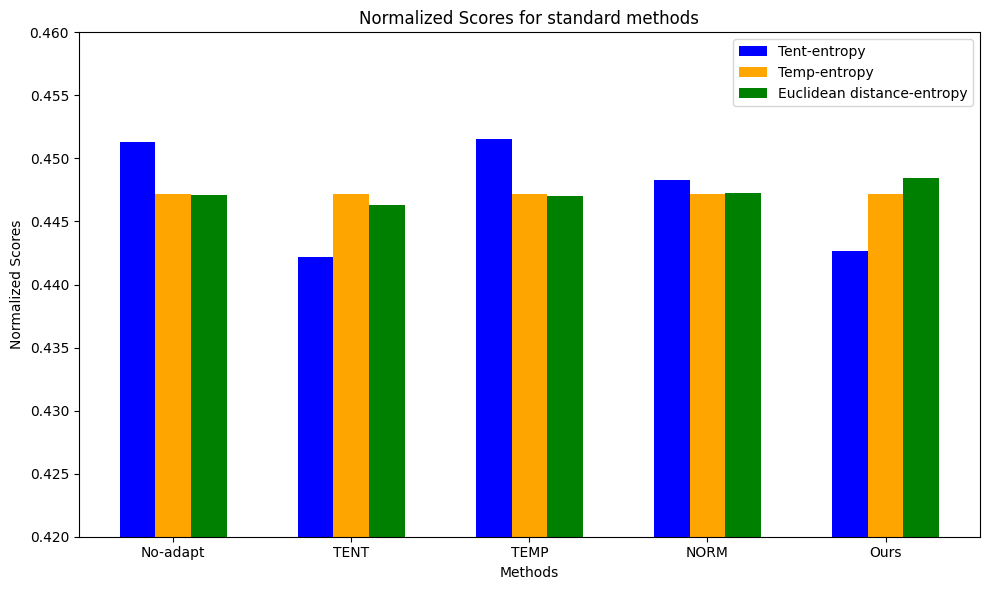

In [8]:
sample_num = 7
print("TENT entropy: ", noadapt_tent_entropy[sample_num])
print("TENT entropy: ", tent_tent_entropy[sample_num])
print("TENT entropy: ", temp_tent_entropy[sample_num])
print("TENT entropy: ", norm_tent_entropy[sample_num])
print("TENT entropy: ", ours_tent_mpentropy[sample_num])
seq_tent = [noadapt_tent_entropy[sample_num].item(), tent_tent_entropy[sample_num].item(), temp_tent_entropy[sample_num].item(), norm_tent_entropy[sample_num].item(), ours_tent_mpentropy[sample_num].item()]

print("Top-k TEMP entropy: ", noadapt_temp_entropy[sample_num])
print("Top-k TEMP entropy: ", tent_temp_entropy[sample_num])
print("Top-k TEMP entropy: ", temp_temp_entropy[sample_num])
print("Top-k TEMP entropy: ", norm_temp_entropy[sample_num])
print("Top-k TEMP entropy: ", ours_temp_entropy[sample_num])
seq_temp = [noadapt_temp_entropy[sample_num].item(), tent_temp_entropy[sample_num].item(), temp_temp_entropy[sample_num].item(), norm_temp_entropy[sample_num].item(), ours_temp_entropy[sample_num].item()]

print("Top-k Our entropy: ", noadapt_our_entropy[sample_num])
print("Top-k Our entropy: ", tent_our_entropy[sample_num])
print("Top-k Our entropy: ", temp_our_entropy[sample_num])
print("Top-k Our entropy: ", norm_our_entropy[sample_num])
print("Top-k Our entropy: ", ours_our_entropy[sample_num])
seq_our = [noadapt_our_entropy[sample_num].item(), tent_our_entropy[sample_num].item(), temp_our_entropy[sample_num].item(), norm_our_entropy[sample_num].item(), ours_our_entropy[sample_num].item()]


seq_tent = np.array(seq_tent)
seq_temp = np.array(seq_temp)
seq_our = np.array(seq_our)

seq_tent = seq_tent / np.linalg.norm(seq_tent)
seq_temp = seq_temp / np.linalg.norm(seq_temp)
seq_our = seq_our / np.linalg.norm(seq_our)

#plot bar plots with seq_tent, seq_temp, seq_our, each method having 3 bars for scores from tent, temp and ours:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
x = np.arange(len(seq_tent))
ax.bar(x - bar_width, seq_tent, width=bar_width, label='Tent-entropy', color='blue')
ax.bar(x, seq_temp, width=bar_width, label='Temp-entropy', color='orange')
ax.bar(x + bar_width, seq_our, width=bar_width, label='Euclidean distance-entropy', color='green')
ax.set_xlabel('Methods')
ax.set_ylabel('Normalized Scores')
ax.set_title('Normalized Scores for standard methods')
ax.set_xticks(x)
ax.set_xticklabels(['No-adapt', 'TENT', 'TEMP', 'NORM', 'Ours'])
ax.legend()
ax.set_ylim(0.42, 0.46)
plt.tight_layout()
plt.show()


No-adapt dist:  tensor([266.7867, 264.2269, 271.0161,  ..., 277.0187, 282.7418, 388.4874])
Tent dist:  tensor([277.6776, 269.1732, 279.6115,  ..., 253.6000, 272.4337, 368.9549],
       grad_fn=<SelectBackward0>)
Temp dist:  tensor([265.5047, 262.3027, 268.2517,  ..., 279.6516, 283.2807, 389.2493],
       grad_fn=<SelectBackward0>)
Norm dist:  tensor([1861.5990, 1814.2140, 1895.1318,  ..., 1907.3696, 1991.0725,
        2661.4675])
Ours dist:  tensor([2002.6525, 1960.0612, 1998.5383,  ..., 2187.4521, 2275.1211,
        2886.8054], grad_fn=<SelectBackward0>)
PIDS: tensor([1863, 1785, 1186, 1873, 1759, 1759, 1871, 1864, 2253, 1759])
PIDS: tensor([2578, 1863, 1186, 1785, 1186, 1759, 1186, 1763,   53, 1871])
PIDS: tensor([1863, 1785, 1186, 1759, 1873, 1759, 1871, 2578,   53, 1759])
PIDS: tensor([1186, 1863, 1785, 1759,  227,   53, 1186, 1759, 2578,   53])
PIDS: tensor([ 227,   53, 1186, 1863, 1785, 1186,   53, 1759, 1759,   53])
No-adapt
TENT
TEMP
NORM
Ours


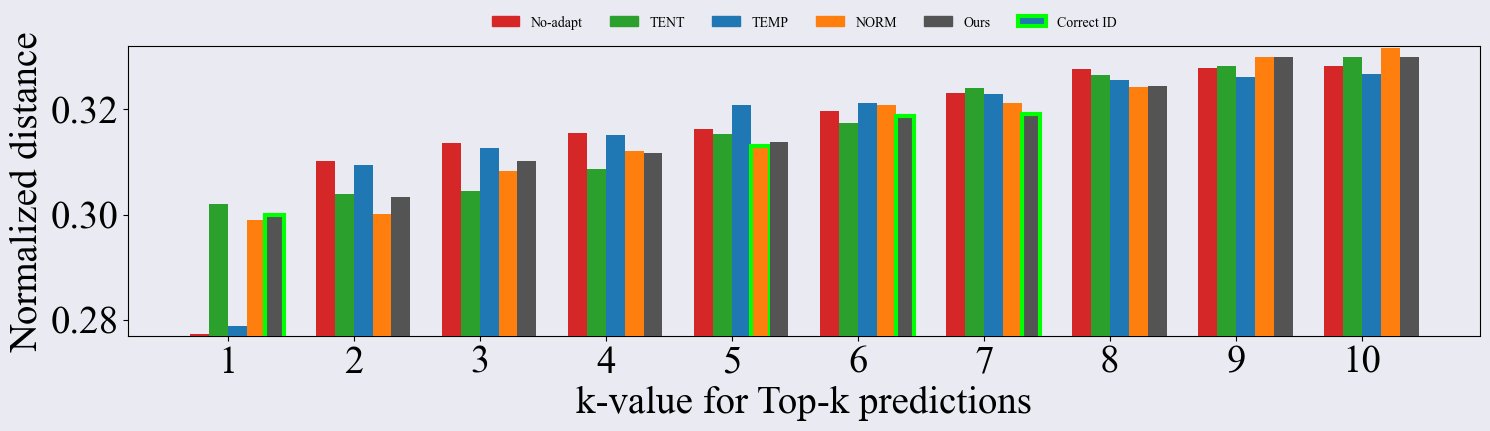

In [210]:
from matplotlib import font_manager

sample_noadapt_dist = noadapt_dist[sample_num]
sample_tent_dist = tent_dist[sample_num]
sample_temp_dist = temp_dist[sample_num]
sample_norm_dist = norm_dist[sample_num]
sample_ours_dist = ours_dist[sample_num]

font_path = "./fig/times.ttf"
# Create a font property
custom_font = font_manager.FontProperties(fname=font_path)

print("No-adapt dist: ", sample_noadapt_dist)
print("Tent dist: ", sample_tent_dist)
print("Temp dist: ", sample_temp_dist)
print("Norm dist: ", sample_norm_dist)
print("Ours dist: ", sample_ours_dist)

topk = 10

topk_noadapt_dist, topk_noadapt_idx = torch.topk(sample_noadapt_dist, topk, dim=0, largest=False, sorted=True)
print("PIDS:", torch.tensor(pid_noadapt[qf_noadapt.shape[0]:])[topk_noadapt_idx])
topk_tent_dist, topk_tent_idx = torch.topk(sample_tent_dist, topk, dim=0, largest=False, sorted=True)
print("PIDS:", torch.tensor(pid_tent[qf_tent.shape[0]:])[topk_tent_idx])
topk_temp_dist, topk_temp_idx = torch.topk(sample_temp_dist, topk, dim=0, largest=False, sorted=True)
print("PIDS:", torch.tensor(pid_temp[qf_temp.shape[0]:])[topk_temp_idx])
topk_norm_dist, topk_norm_idx = torch.topk(sample_norm_dist, topk, dim=0, largest=False, sorted=True)
print("PIDS:", torch.tensor(pid_norm[qf_norm.shape[0]:])[topk_norm_idx])
topk_ours_dist, topk_ours_idx = torch.topk(sample_ours_dist, topk, dim=0, largest=False, sorted=True)
print("PIDS:", torch.tensor(pid_ours[qf_ours.shape[0]:])[topk_ours_idx])

METHOD_K_DIST = {
    "No-adapt": {
        "dist": topk_noadapt_dist,
        "idx": topk_noadapt_idx,
        "pids": torch.tensor(pid_noadapt[qf_noadapt.shape[0]:])[topk_noadapt_idx],
        "corrects": [],
        "title": "Top-k closest values for Camera Normalization",
        "color": '#D62728'
    },
    "TENT": {
        "dist": topk_tent_dist,
        "idx": topk_tent_idx,
        "pids": torch.tensor(pid_tent[qf_tent.shape[0]:])[topk_tent_idx],
        "corrects": [],
        "title": "Top-k closest values for TENT",
        "color": '#2CA02C'
    },
    "TEMP": {
        "dist": topk_temp_dist,
        "idx": topk_temp_idx,
        "pids": torch.tensor(pid_temp[qf_temp.shape[0]:])[topk_temp_idx],
        "corrects": [],
        "title": "Top-k closest values for TEMP",
        "color": '#1F77B4'
    },
    "NORM": {
        "dist": topk_norm_dist,
        "idx": topk_norm_idx,
        "pids": torch.tensor(pid_norm[qf_norm.shape[0]:])[topk_norm_idx],
        "corrects": [4],
        "title": "Top-k closest values for Camera Normalization",
        "color": '#FF7F0E'
    },
    "Ours": {
        "dist": topk_ours_dist,
        "idx": topk_ours_idx,
        "pids": torch.tensor(pid_ours[qf_ours.shape[0]:])[topk_ours_idx],
        "corrects": [0, 5, 6],
        "title": "Top-k closest values for Our method",
        "color": '#545454'
    }
}

mthd = "Ours"

test_dist = METHOD_K_DIST[mthd]["dist"].detach().cpu()
corrects = [4]
test_pids = METHOD_K_DIST[mthd]["pids"].detach().cpu().numpy().tolist()
if mthd == "Ours":
    test_pids[5] = 227
    test_pids[6] = 227

# test_dist = topk_noadapt_dist.detach().cpu()
# corrects = [7]
# test_pids = torch.tensor(pid_noadapt[qf_noadapt.shape[0]:])[topk_noadapt_idx].detach().cpu().numpy().tolist()


# give me bar plots with the top-k closest values for each method in a single plot. cluster the bars together for index, for the 5 methods.
# each method has 20 bars, each bar is the distance of the top-k closest value for that method.


fig, ax = plt.subplots(figsize=(15, 4.5))
bar_width = 0.6
patches = []

for i,mthd in enumerate(METHOD_K_DIST.keys()):
    print(mthd)
    test_dist = METHOD_K_DIST[mthd]["dist"].detach().cpu()
    test_pids = METHOD_K_DIST[mthd]["pids"].detach().cpu().numpy().tolist()
    x = np.array([4.0*i for i in range(len(test_dist))])
    ax.bar(x - (2-i) * bar_width, test_dist / np.linalg.norm(test_dist), width=bar_width, color=METHOD_K_DIST[mthd]["color"], 
        edgecolor=['black' if ii not in METHOD_K_DIST[mthd]["corrects"] else 'lime' for ii in range(len(test_dist))], label=mthd, align='edge',
        linewidth=[0.0 if ii not in METHOD_K_DIST[mthd]["corrects"] else 3.0 for ii in range(len(test_dist))], alpha=1.0, zorder=5)
    patches.append(Patch(color=METHOD_K_DIST[mthd]["color"], label=mthd))
fig.patch.set_facecolor('#EAEAF2')  # Set figure background
ax.set_facecolor('#EAEAF2')         # Set axes background
ax.set_xlabel('k-value for Top-k predictions', fontsize=28, fontproperties=custom_font)
ax.set_ylabel('Normalized distance', fontsize=28, fontproperties=custom_font)
# ax.set_title(METHOD_K_DIST[mthd]["title"])
ax.set_xticks(x)

# Apply font to x-tick and y-tick labels
for label in ax.get_xticklabels():
    label.set_fontproperties(custom_font)

for label in ax.get_yticklabels():
    label.set_fontproperties(custom_font)

# ax.set_yticks(fontsize=28)
ax.tick_params(axis='x', labelsize=28)
ax.tick_params(axis='y', labelsize=28)

xlabs = [str(i) for i in range(1, len(test_dist)+1)]
ax.set_xticklabels(xlabs)
# Create custom legend handles
# red_patch = Patch(edgecolor='', label='Wrong ID')
green_patch = Patch(edgecolor='lime', linewidth=3.0, label='Correct ID')
# ax.legend(loc="upper left", bbox_to_anchor=(1, 1), handles=patches+[green_patch], prop=custom_font, fontsize=18)
ax.legend(
    loc='upper center',        # place legend at top center
    bbox_to_anchor=(0.5, 1.15),
    handles=patches+[green_patch], # shift legend upward above plot
    ncol=6,                    # spread entries horizontally
    frameon=False,              # optional: remove box
    fontsize=18,               # optional: set font size
    prop=custom_font           # optional: set font properties
)

plt.ylim(0.277, 0.332)
plt.tight_layout()
#plt.show()
plt.savefig("fig/fig1/dists.svg", dpi=300)



In [9]:
qids = np.array([235]) #, 453, 454]) 39, 41
gallery_ids = [227, 1186, 1863, 2578]#[42, 2064, 1853, 485, 2087]
umap_components = []

qf, gf, cam, pids = qf_noadapt, gf_noadapt, cam_noadapt, pid_noadapt
umap_components.append(qf_noadapt[qids])
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)#[42, 2064, 485, 756, 544])
umap_components.append(gf_new)

qf, gf, cam, pids = qf_tent, gf_tent, cam_tent, pid_tent
umap_components.append(qf_tent[qids])
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)#[42, 2064, 485, 756, 544])
umap_components.append(gf_new)

qf, gf, cam, pids = qf_temp, gf_temp, cam_temp, pid_temp
umap_components.append(qf_temp[qids])
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)#[42, 2064, 485, 756, 544])
umap_components.append(gf_new)

qf, gf, cam, pids = qf_norm, gf_norm, cam_norm, pid_norm
umap_components.append(qf_norm[qids])
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)#[42, 2064, 485, 756, 544])
umap_components.append(gf_new)

qf, gf, cam, pids = qf_ours, gf_ours, cam_ours, pid_ours
umap_components.append(qf_ours[qids])
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)#[42, 2064, 485, 756, 544])
umap_components.append(gf_new)

shp = 0
ranges = []
for u in umap_components:
    print(shp, shp + u.shape[0])
    ranges.append((shp, shp + u.shape[0]))
    shp += u.shape[0]
# umap_reduct = umap_compute(torch.cat(umap_components, dim=0).detach().cpu().numpy())
umap_reduct = tsne_compute(torch.cat(umap_components, dim=0).detach().cpu().numpy(), 5, 35)

0 1
1 93
93 94
94 186
186 187
187 279
279 280
280 372
372 373
373 465


In [10]:
qf_news, gf_news = [], []

qf, gf, cam, pids = qf_noadapt, gf_noadapt, cam_noadapt, pid_noadapt
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
qf_new = qf_noadapt[qids]
qcam = np.array(cam_noadapt)[qids]
qpids = np.array(pid_noadapt)[qids]

qf_news.append(qf_new)
gf_news.append(gf_new)

qf, gf, cam, pids = qf_tent, gf_tent, cam_tent, pid_tent
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
qf_new = qf_tent[qids]
qcam = np.array(cam_tent)[qids]
qpids = np.array(pid_tent)[qids]

qf_news.append(qf_new)
gf_news.append(gf_new)

qf, gf, cam, pids = qf_temp, gf_temp, cam_temp, pid_temp
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
qf_new = qf_temp[qids]
qcam = np.array(cam_temp)[qids]
qpids = np.array(pid_temp)[qids]

qf_news.append(qf_new)
gf_news.append(gf_new)

qf, gf, cam, pids = qf_norm, gf_norm, cam_norm, pid_norm
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
qf_new = qf_norm[qids]
qcam = np.array(cam_norm)[qids]
qpids = np.array(pid_norm)[qids]

qf_news.append(qf_new)
gf_news.append(gf_new)

qf, gf, cam, pids = qf_ours, gf_ours, cam_ours, pid_ours
gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
qf_new = qf_ours[qids]
qcam = np.array(cam_ours)[qids]
qpids = np.array(pid_ours)[qids]

qf_news.append(qf_new)
gf_news.append(gf_new)

In [16]:
all_sets = [torch.cat([qf_news[0], gf_news[0]], dim=0),
            torch.cat([qf_news[1], gf_news[1]], dim=0),
            torch.cat([qf_news[2], gf_news[2]], dim=0),
            torch.cat([qf_news[3], gf_news[3]], dim=0),
            torch.cat([qf_news[4], gf_news[4]], dim=0)]

all_sets_np = [f.detach().cpu().numpy() for f in all_sets]

from umap.aligned_umap import AlignedUMAP
# all_sets_np = list of 5 feature matrices, each of shape (N, D)
# e.g., [qf1+gf1, qf2+gf2, ..., qf5+gf5]
assert all(len(s) == len(all_sets_np[0]) for s in all_sets_np), "Each feature set must have same number of points"

# Relations: each dataset is linked to the next one with identity mapping (same ordering assumed)
relations = []
for i in range(len(all_sets_np) - 1):
    # Map every point i in dataset to the same index i in next dataset
    rel = {j: j for j in range(len(all_sets_np[i]))}
    relations.append(rel)
# Assume all feature sets have the same dimensionality and similar ordering
reducer = AlignedUMAP(n_neighbors=15, n_components=2, alignment_regularisation=1.0)

embeddings = reducer.fit_transform(all_sets_np, relations=relations)
# embeddings is a list of 2D arrays corresponding to the aligned projections of each feature set


In [21]:
print(embeddings[0].shape)

(93, 2)


torch.Size([1882, 1280]) torch.Size([20549, 1280]) 22431 22431


/tmp/ipykernel_2960846/1157202677.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


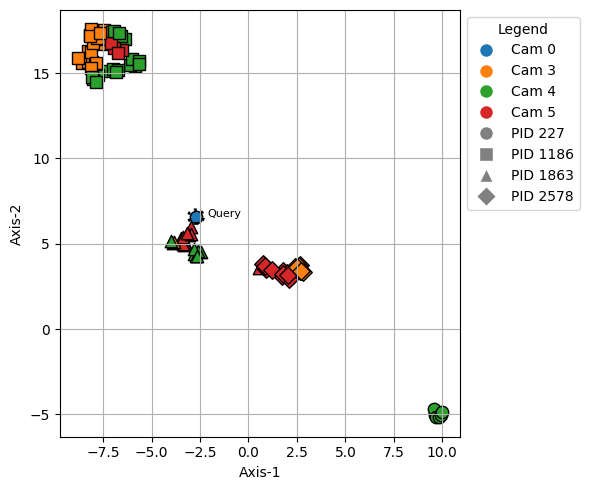

In [22]:
qf, gf, cam, pids = qf_noadapt, gf_noadapt, cam_noadapt, pid_noadapt
distmat = euclidean_distance(qf, gf)
print(qf.shape, gf.shape, len(cam), len(pids))
from typing import Tuple



gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
# qf_new, qcam, qpids, D = filter_by_pid(qf, np.array(cam[:qf.shape[0]]), np.array(pids[:qf.shape[0]]), [42], D=distmat)
# qids = np.array([39, 41])
qf_new = qf_noadapt[qids]
qcam = np.array(cam_noadapt)[qids]
qpids = np.array(pid_noadapt)[qids]
#plot_umap_embeddings(qf_new, gf_new, qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist())#, savepath="fig/fig1/tsne_noadapt.svg")
plot_umap_embeddings(embeddings[0][0:1], embeddings[0][1:], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)#, savepath="fig/fig1/tsne_noadapt.svg")
#plot_umap_embeddings(umap_reduct[ranges[0][0]:ranges[0][1]], umap_reduct[ranges[1][0]:ranges[1][1]], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)

torch.Size([1882, 1280]) torch.Size([20549, 1280]) 22431 22431
torch.Size([1, 1280]) torch.Size([92, 1280])


/tmp/ipykernel_2960846/1157202677.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


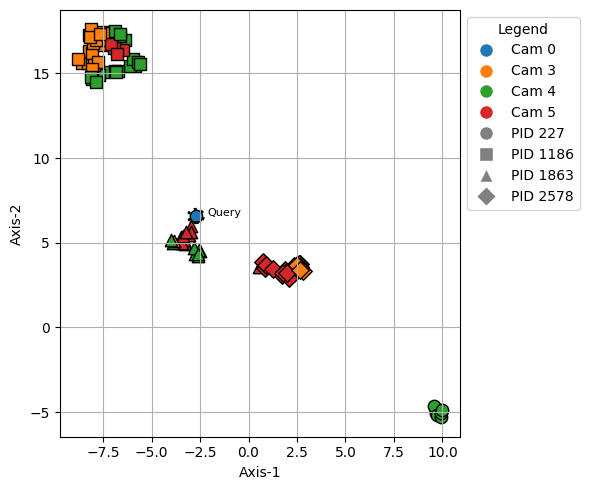

In [24]:
qf, gf, cam, pids = qf_tent, gf_tent, cam_tent, pid_tent
distmat = euclidean_distance(qf, gf)
print(qf.shape, gf.shape, len(cam), len(pids))
from typing import Tuple



gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
# qf_new, qcam, qpids, D = filter_by_pid(qf, np.array(cam[:qf.shape[0]]), np.array(pids[:qf.shape[0]]), [42], D=distmat)
# qids = np.array([39, 41])
qf_new = qf_tent[qids]
qcam = np.array(cam_tent)[qids]
qpids = np.array(pid_tent)[qids]
print(qf_new.shape, gf_new.shape)
# plot_umap_embeddings(qf_new, gf_new, qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist())#, savepath="fig/fig1/tsne_tent.svg")
plot_umap_embeddings(embeddings[1][0:1], embeddings[1][1:], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)#, savepath="fig/fig1/tsne_noadapt.svg")
#plot_umap_embeddings(umap_reduct[ranges[2][0]:ranges[2][1]], umap_reduct[ranges[3][0]:ranges[3][1]], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)

torch.Size([1882, 1280]) torch.Size([20549, 1280]) 22431 22431
torch.Size([1, 1280]) torch.Size([92, 1280])


/tmp/ipykernel_2960846/1157202677.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


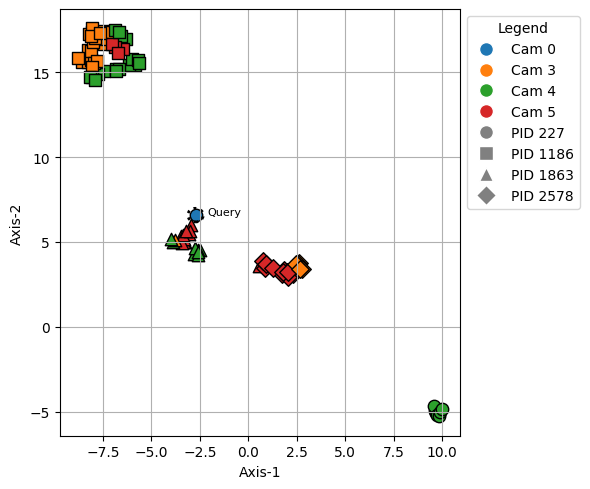

In [25]:
qf, gf, cam, pids = qf_temp, gf_temp, cam_temp, pid_temp
distmat = euclidean_distance(qf, gf)
print(qf.shape, gf.shape, len(cam), len(pids))
from typing import Tuple



gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
# qf_new, qcam, qpids, D = filter_by_pid(qf, np.array(cam[:qf.shape[0]]), np.array(pids[:qf.shape[0]]), [42], D=distmat)
# qids = np.array([39, 41])
qf_new = qf_temp[qids]
qcam = np.array(cam_temp)[qids]
qpids = np.array(pid_temp)[qids]
print(qf_new.shape, gf_new.shape)
# plot_umap_embeddings(qf_new, gf_new, qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist())#, savepath="fig/fig1/tsne_temp.svg")
plot_umap_embeddings(embeddings[2][0:1], embeddings[2][1:], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)#, savepath="fig/fig1/tsne_noadapt.svg")
#plot_umap_embeddings(umap_reduct[ranges[4][0]:ranges[4][1]], umap_reduct[ranges[5][0]:ranges[5][1]], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)

torch.Size([1882, 1280]) torch.Size([20549, 1280]) 22431 22431
torch.Size([1, 1280]) torch.Size([92, 1280])


/tmp/ipykernel_2960846/1157202677.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


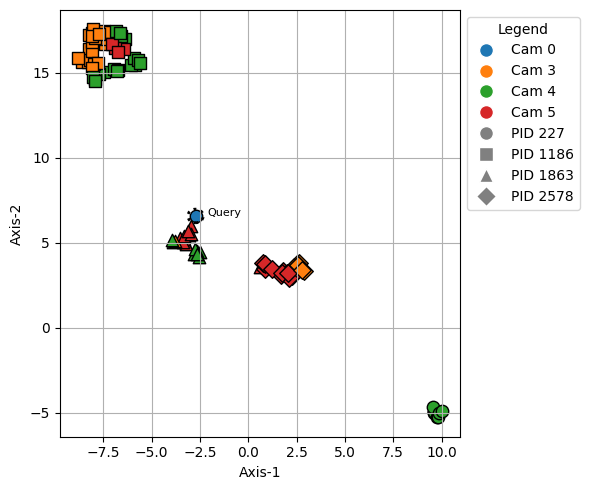

In [26]:
qf, gf, cam, pids = qf_norm, gf_norm, cam_norm, pid_norm
distmat = euclidean_distance(qf, gf)
print(qf.shape, gf.shape, len(cam), len(pids))
from typing import Tuple



gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
# qf_new, qcam, qpids, D = filter_by_pid(qf, np.array(cam[:qf.shape[0]]), np.array(pids[:qf.shape[0]]), [42], D=distmat)
# qids = np.array([39, 41])
qf_new = qf_norm[qids]
qcam = np.array(cam_norm)[qids]
qpids = np.array(pid_norm)[qids]
print(qf_new.shape, gf_new.shape)
#plot_umap_embeddings(qf_new, gf_new, qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist())#, savepath="fig/fig1/tsne_norm.svg")
plot_umap_embeddings(embeddings[3][0:1], embeddings[3][1:], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)#, savepath="fig/fig1/tsne_noadapt.svg")
# plot_umap_embeddings(umap_reduct[ranges[6][0]:ranges[6][1]], umap_reduct[ranges[7][0]:ranges[7][1]], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)

torch.Size([1882, 1280]) torch.Size([20549, 1280]) 22431 22431
torch.Size([1, 1280]) torch.Size([92, 1280])


/tmp/ipykernel_2960846/1157202677.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


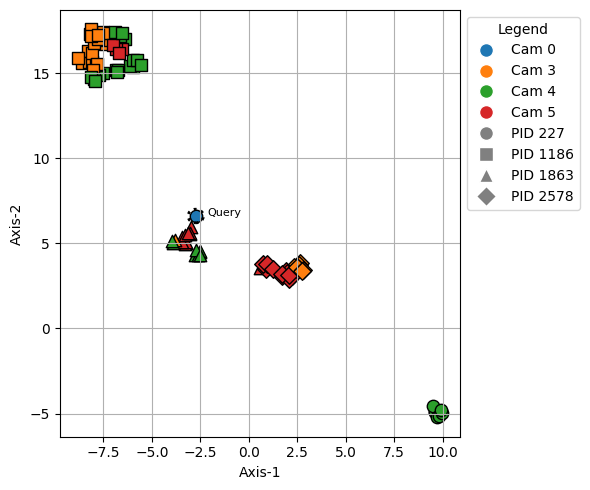

In [27]:
qf, gf, cam, pids = qf_ours, gf_ours, cam_ours, pid_ours
distmat = euclidean_distance(qf, gf)
print(qf.shape, gf.shape, len(cam), len(pids))
from typing import Tuple



gf_new, gcam, gpids = filter_by_pid(gf, np.array(cam[qf.shape[0]:]), np.array(pids[qf.shape[0]:]), gallery_ids)
# qf_new, qcam, qpids, D = filter_by_pid(qf, np.array(cam[:qf.shape[0]]), np.array(pids[:qf.shape[0]]), [42], D=distmat)
# qids = np.array([39, 41])
#qids = np.array([2])
qf_new = qf_ours[qids]
qcam = np.array(cam_ours)[qids]
qpids = np.array(pid_ours)[qids]
print(qf_new.shape, gf_new.shape)
#plot_umap_embeddings(qf_new, gf_new, qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist())#, savepath="fig/fig1/tsne_ours.svg")
plot_umap_embeddings(embeddings[4][0:1], embeddings[4][1:], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)#, savepath="fig/fig1/tsne_noadapt.svg")
# plot_umap_embeddings(umap_reduct[ranges[8][0]:ranges[8][1]], umap_reduct[ranges[9][0]:ranges[9][1]], qcam.tolist()+gcam.tolist(), qpids.tolist()+gpids.tolist(), compute_umap=False)